# 📘 Data Merging & Cleaning – Yousra Descriptive Stats Notebook

This notebook loads the original project datasets (sales, weather, kiwo event),  
cleans and standardizes the date format, merges them using a full outer join,  
and performs descriptive statistics, missing value inspection, and prepares the  
data for further feature engineering and modeling.

The goal is to:
1. Combine **all available data** on matching dates  
2. Perform a clear descriptive exploration  
3. Detect and handle missing values  
4. Produce a clean dataset ready for analysis  


In [59]:
import pandas as pd
import numpy as np

# Load data from your project folder
df_kiwo = pd.read_csv("../data/kiwo.csv")
df_weather = pd.read_csv("../data/wetter.csv")
df_sales = pd.read_csv("../data/umsatzdaten_gekuerzt.csv")
df_test = pd. read_csv("../data/test.csv")

#df_kiwo.head(), df_weather.head(), df_sales.head()
#print number of rows for each dataframe
print(f"Kiwo Data Rows: {len(df_kiwo)}")
print(f"Weather Data Rows: {len(df_weather)}")
print(f"sales Data Rows: {len(df_sales)}")
print(f"Test data frame Rows:{len(df_test)}")


Kiwo Data Rows: 72
Weather Data Rows: 2601
sales Data Rows: 9334
Test data frame Rows:1830


In [60]:
# Convert 'Datum' to proper datetime format and drop invalid rows
for df in (df_kiwo, df_weather, df_sales, df_test):
    df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce").dt.normalize()
    df.dropna(subset=["Datum"], inplace=True)

    # Drop duplicate date columns if exist
    if "date" in df.columns:
        df.drop(columns=["date"], inplace=True)
df_test.info(), df_weather.info(), df_sales.info(),df_kiwo.info(),


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           1830 non-null   int64         
 1   Datum        1830 non-null   datetime64[ns]
 2   Warengruppe  1830 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 43.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601 entries, 0 to 2600
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                2601 non-null   datetime64[ns]
 1   Bewoelkung           2591 non-null   float64       
 2   Temperatur           2601 non-null   float64       
 3   Windgeschwindigkeit  2601 non-null   int64         
 4   Wettercode           1932 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 101.7 KB
<class 'pandas.

(None, None, None, None)

In [61]:
# Adding suffixes helps avoid confusion during merging

df_kiwo = df_kiwo.add_suffix("_kiwo")
df_kiwo.rename(columns={"Datum_kiwo": "Datum"}, inplace=True)

df_weather = df_weather.add_suffix("_weather")
df_weather.rename(columns={"Datum_weather": "Datum"}, inplace=True)


df_sales = df_sales.add_suffix("_umsatz")
df_sales.rename(columns={"Datum_umsatz": "Datum"}, inplace=True)

df_sales["umsatz_rolling7"] = (
    df_sales["Umsatz_umsatz"].rolling(window=7, min_periods=1).mean()
)

# add suffix to df_test columns
df_test = df_test.add_suffix("_test")
df_test.rename(columns={"Datum_test": "Datum"}, inplace=True)


In [62]:
# print start and end dates for each dataframe
for name, df in [("Kiwo", df_kiwo), ("Weather", df_weather), ("Sales", df_sales), ("Test", df_test)]:
    print(
        f"{name} Data: Start Date = {df['Datum'].min().date()}, End Date = {df['Datum'].max().date()}"
    ) 

Kiwo Data: Start Date = 2012-06-16, End Date = 2019-06-30
Weather Data: Start Date = 2012-01-01, End Date = 2019-08-01
Sales Data: Start Date = 2013-07-01, End Date = 2018-07-31
Test Data: Start Date = 2018-08-01, End Date = 2019-07-30


In [63]:
# generate descriptive statistics for each dataframe
for name, df in [("Weather", df_weather), ("Sales", df_sales),("Kiwo", df_kiwo)]:
    print(f"\nDescriptive Statistics for {name} Data:")
    print(df.describe(include="all"))

display(df_sales.isna().sum(), df_weather.isna().sum(), df_kiwo.isna().sum())


Descriptive Statistics for Weather Data:
                               Datum  Bewoelkung_weather  Temperatur_weather  \
count                           2601         2591.000000         2601.000000   
mean   2015-12-07 00:08:18.269896192            4.805866           12.099586   
min              2012-01-01 00:00:00            0.000000          -10.250000   
25%              2014-03-14 00:00:00            3.000000            6.512500   
50%              2015-12-24 00:00:00            6.000000           12.000000   
75%              2017-10-07 00:00:00            7.000000           17.825000   
max              2019-08-01 00:00:00            8.000000           32.671428   
std                              NaN            2.578299            7.174357   

       Windgeschwindigkeit_weather  Wettercode_weather  
count                  2601.000000         1932.000000  
mean                     11.191080           37.484472  
min                       3.000000            0.000000  
25%      

id_umsatz             0
Datum                 0
Warengruppe_umsatz    0
Umsatz_umsatz         0
umsatz_rolling7       0
dtype: int64

Datum                            0
Bewoelkung_weather              10
Temperatur_weather               0
Windgeschwindigkeit_weather      0
Wettercode_weather             669
dtype: int64

Datum               0
KielerWoche_kiwo    0
dtype: int64

## Visualize dataframe for gaps
We can now use this function for any data set in this playbook

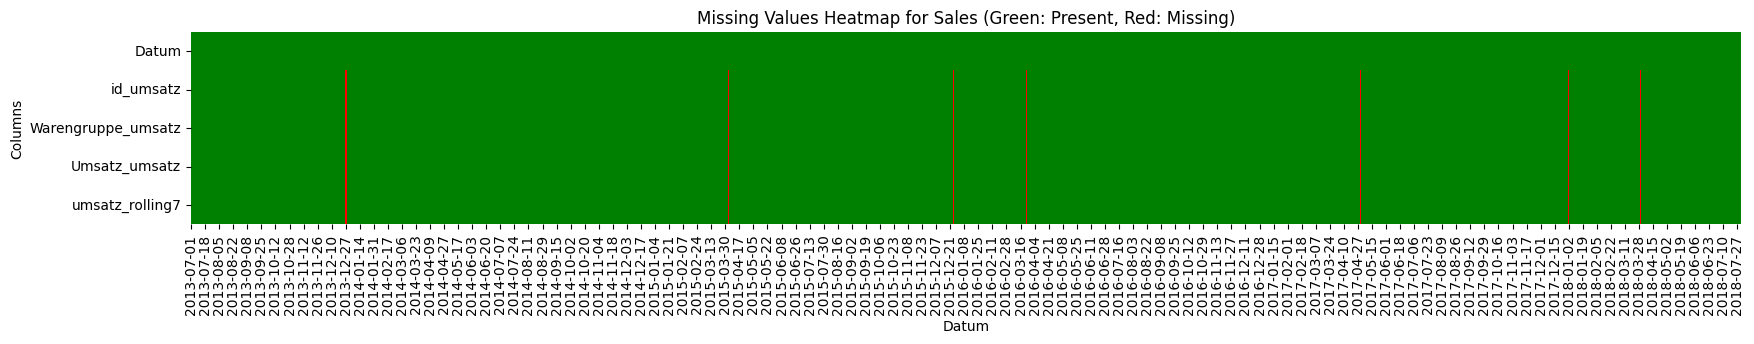

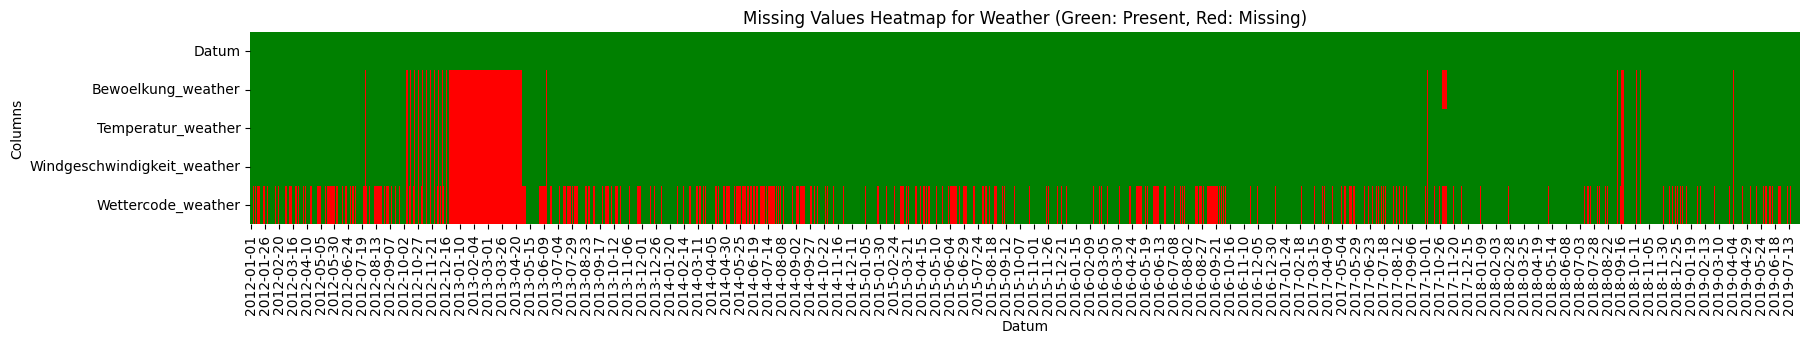

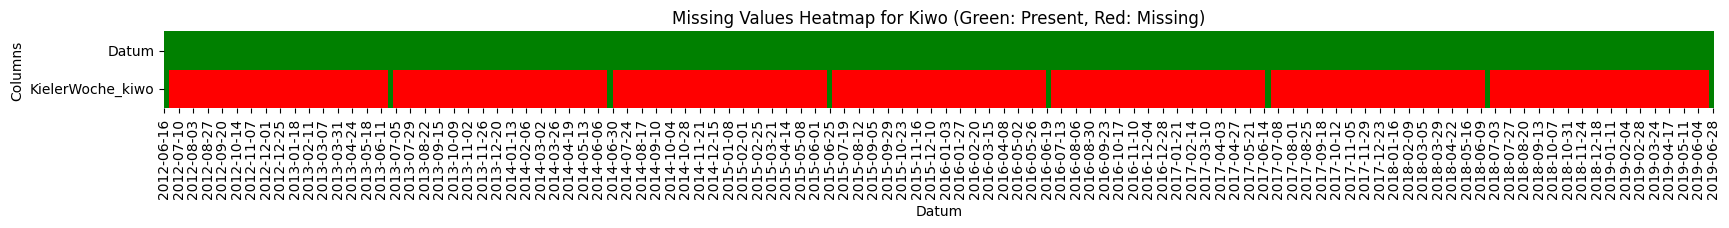

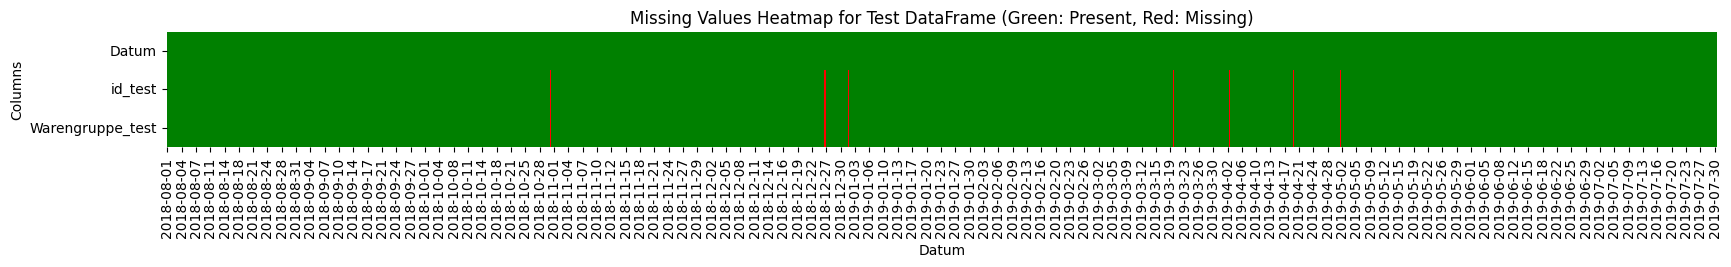

In [64]:
import sys
sys.path.append('..')  # Add project root to path for imports
from utils import plot_missing_heatmap

# Plot for each dataframe
plot_missing_heatmap(df_sales, 'Sales')
plot_missing_heatmap(df_weather, 'Weather')
plot_missing_heatmap(df_kiwo, 'Kiwo')
plot_missing_heatmap(df_test, 'Test DataFrame')

In [65]:
# Merging dataframes on 'Datum' using outer joins to retain all records
merged_df = (
    df_kiwo
    .merge(df_weather, on="Datum", how="outer")
    .merge(df_sales, on="Datum", how="outer")
)

# Merging test dataframe as well
merged_df = merged_df.merge(df_test, on="Datum", how="outer")
display(merged_df.shape)
display(merged_df.head())


(11607, 12)

,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Wettercode_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,id_test,Warengruppe_test
0,2012-01-01,NaN,8.0,9.8250,14.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,NaN,7.0,7.4375,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-03,NaN,8.0,5.5375,18.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-04,NaN,4.0,5.6875,19.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-05,NaN,6.0,5.3000,23.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN


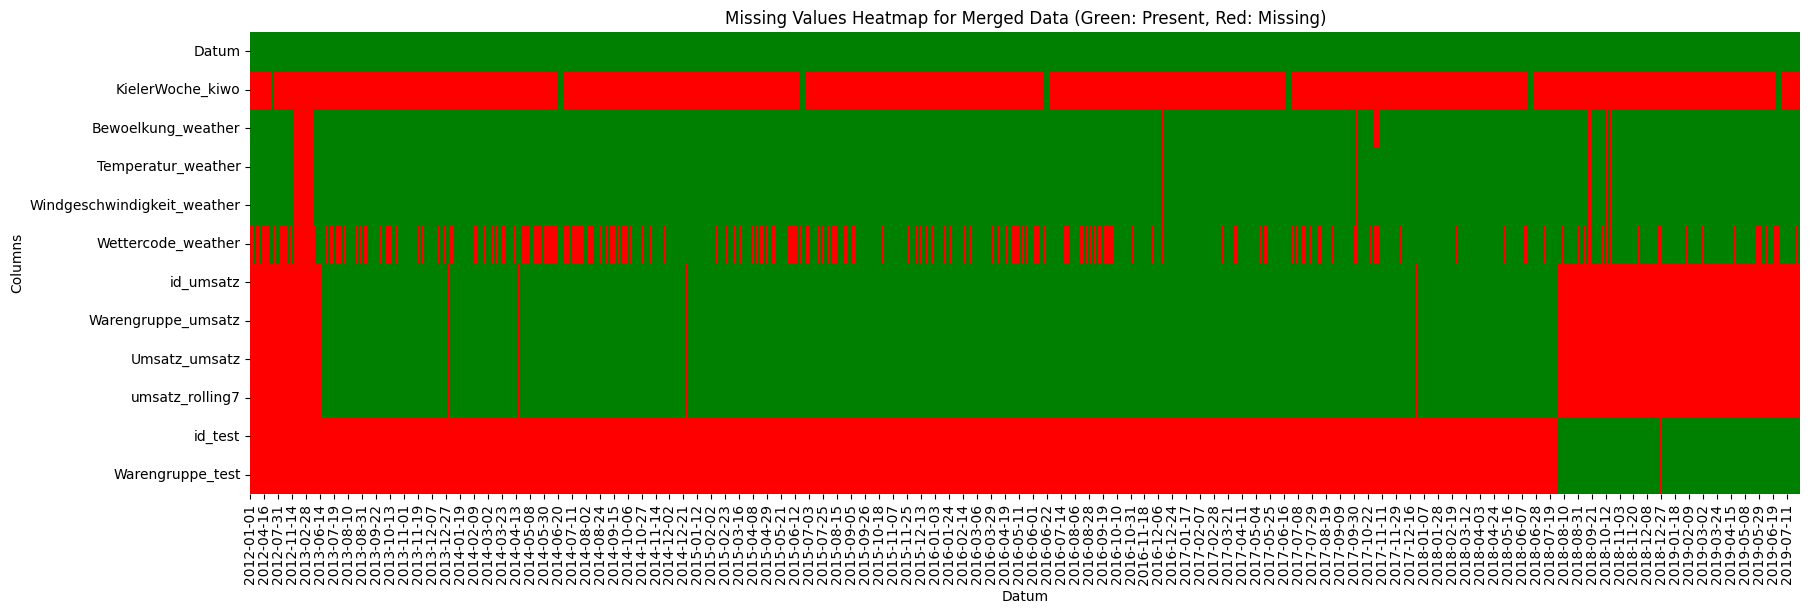

In [66]:
plot_missing_heatmap(merged_df, 'Merged Data')

In [67]:
# Numeric summary
merged_df.describe()

# For all columns (including categorical)
merged_df.describe(include="all")


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Wettercode_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,id_test,Warengruppe_test
count,11607,286.0,11471.000000,11526.000000,11526.000000,8785.000000,9.334000e+03,9334.000000,9334.000000,9334.000000,1.830000e+03,1830.000000
mean,2016-05-26 14:45:48.617213696,1.0,4.759655,12.005803,11.046157,36.456346,1.559311e+06,3.088172,206.749044,206.776906,1.862845e+06,3.091257
min,2012-01-01 00:00:00,1.0,0.000000,-10.250000,3.000000,0.000000,1.307011e+06,1.000000,7.051201,28.664341,1.808011e+06,1.000000
25%,2014-11-11 00:00:00,1.0,3.000000,6.250000,8.000000,10.000000,1.410123e+06,2.000000,96.897441,101.285593,1.811013e+06,2.000000
50%,2016-06-05 00:00:00,1.0,6.000000,11.625000,10.000000,22.000000,1.601102e+06,3.000000,161.900831,154.098561,1.901238e+06,3.000000
75%,2017-12-28 00:00:00,1.0,7.000000,17.775000,13.000000,61.000000,1.704223e+06,4.000000,280.644663,290.012266,1.904283e+06,4.000000
max,2019-08-01 00:00:00,1.0,8.000000,32.671428,35.000000,95.000000,1.807315e+06,6.000000,1879.461831,746.064991,1.907305e+06,6.000000
std,NaN,0.0,2.631881,7.199261,4.132464,27.293699,1.512503e+05,1.489002,144.545189,131.740326,4.667232e+04,1.485810


In [68]:
missing_count = merged_df.isna().sum()
missing_percent = (merged_df.isna().sum() / len(merged_df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing_count,
    "Missing %": missing_percent
})

missing_df


,Missing Count,Missing %
Datum,0,0.000000
KielerWoche_kiwo,11321,97.535970
Bewoelkung_weather,136,1.171707
Temperatur_weather,81,0.697855
Windgeschwindigkeit_weather,81,0.697855
Wettercode_weather,2822,24.312915
id_umsatz,2273,19.583010
Warengruppe_umsatz,2273,19.583010
Umsatz_umsatz,2273,19.583010
umsatz_rolling7,2273,19.583010


### ✔️ Missing Value Strategy

**Umsatz (Sales):**
- Missing values mean the day has **no sales** or is **outside the bakery event period**.
- These rows should be **removed**, not imputed.

**Weather Variables:**
- Weather data may be missing because not all dates have weather records.
- Fill missing values using interpolation (numerical)  
  and assign -1 for Wettercode to indicate “unknown weather”.

**Kiwo Event Flag:**
- If missing → fill with 0 (day outside event).


In [69]:
clean_df = merged_df.copy()

# Remove rows where sales are missing
#clean_df = clean_df.dropna(subset=["Umsatz_umsatz"])

# Fill missing Wettercode with category -1
#if "Wettercode_weather" in clean_df.columns:
    # clean_df["Wettercode_weather"] = clean_df["Wettercode_weather"].fillna(-1)

# Interpolate numerical weather values
# for col in clean_df.columns:
    # if ("_weather" in col) and (clean_df[col].dtype in ["float64", "int64"]):
        # clean_df[col] = clean_df[col].interpolate()

clean_df.isna().sum()


Datum                              0
KielerWoche_kiwo               11321
Bewoelkung_weather               136
Temperatur_weather                81
Windgeschwindigkeit_weather       81
Wettercode_weather              2822
id_umsatz                       2273
Warengruppe_umsatz              2273
Umsatz_umsatz                   2273
umsatz_rolling7                 2273
id_test                         9777
Warengruppe_test                9777
dtype: int64

In [70]:
clean_df["KielerWoche_kiwo"] = clean_df["KielerWoche_kiwo"].fillna(0)


In [71]:
clean_df.isna().sum()


Datum                             0
KielerWoche_kiwo                  0
Bewoelkung_weather              136
Temperatur_weather               81
Windgeschwindigkeit_weather      81
Wettercode_weather             2822
id_umsatz                      2273
Warengruppe_umsatz             2273
Umsatz_umsatz                  2273
umsatz_rolling7                2273
id_test                        9777
Warengruppe_test               9777
dtype: int64

## Visualizing cleaned dataset

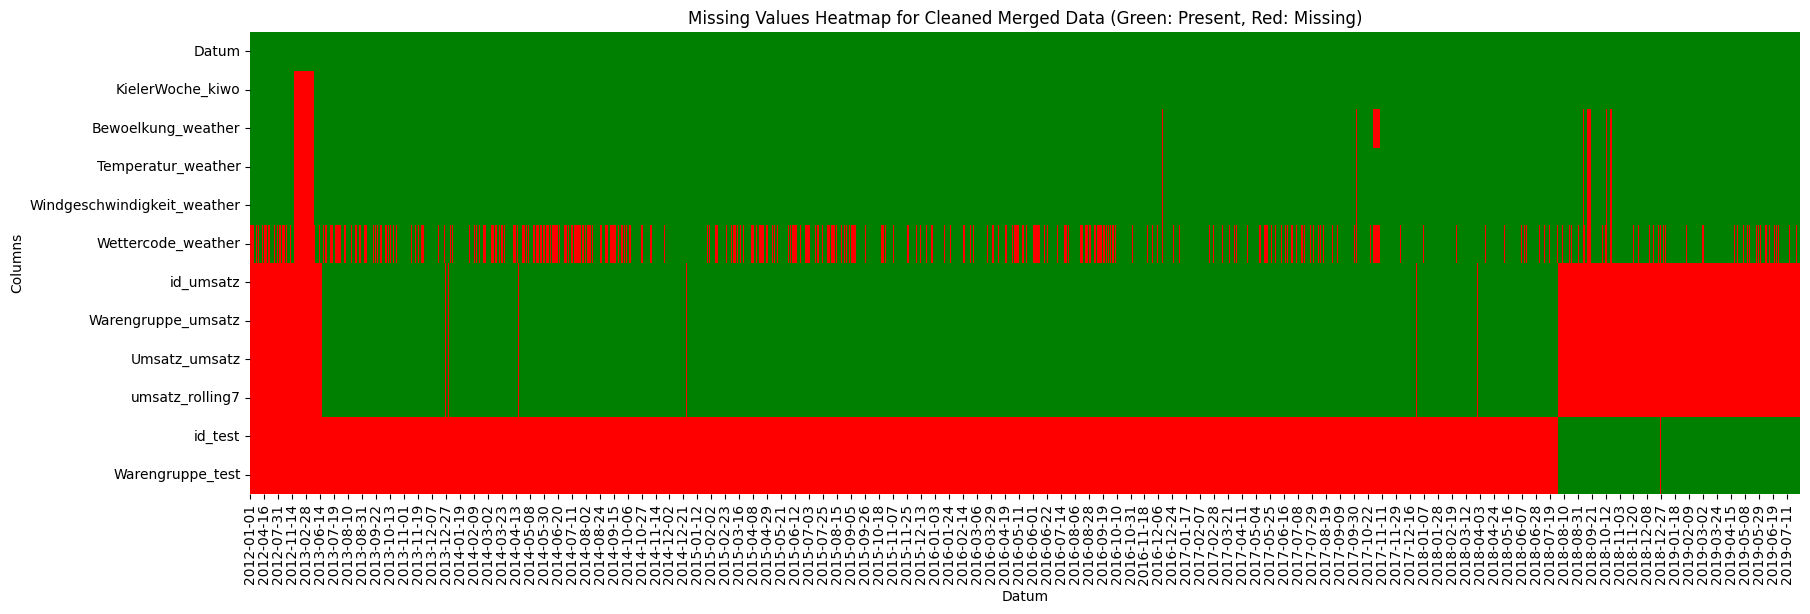

In [72]:
plot_missing_heatmap(clean_df, 'Cleaned Merged Data')

In [73]:
#drop wettercode_weather column
df_no_weather_code = clean_df.drop(columns=["Wettercode_weather"])
df_no_weather_code.sample(5)



,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,id_test,Warengruppe_test
2812,2014-10-27,0.0,2.0,14.5000,9.0,1410272.0,2.0,408.229594,471.683301,NaN,NaN
8169,2017-09-20,0.0,7.0,14.2250,10.0,1709203.0,3.0,115.927685,147.291019,NaN,NaN
5600,2016-04-25,0.0,8.0,4.6250,10.0,1604254.0,4.0,81.525871,79.623027,NaN,NaN
624,2013-08-17,0.0,6.0,20.5500,7.0,1308174.0,4.0,96.529314,87.060398,NaN,NaN
9327,2018-05-04,0.0,0.0,12.1875,10.0,1805043.0,3.0,114.107429,131.828160,NaN,NaN


## Adding extra columns

In [74]:
df_no_weather_code['Datum'] = pd.to_datetime(df_no_weather_code['Datum'], errors='coerce').dt.normalize()
n_invalid = df_no_weather_code['Datum'].isna().sum()
if n_invalid > 0:
    print(f"Warning: {n_invalid} rows have invalid 'Datum' and will have NaT in day columns. Sample:")
    display(df_no_weather_code[df_no_weather_code['Datum'].isna()].head())

# Create integer and name columns for day of week
df_no_weather_code['day_of_week'] = df_no_weather_code['Datum'].dt.weekday  # Monday=0 .. Sunday=6
df_no_weather_code['day'] = df_no_weather_code['Datum'].dt.day_name()

# also add  is_saturday and is_sunday columns
df_no_weather_code['is_saturday'] = (df_no_weather_code['day_of_week'] == 5).astype(int)
df_no_weather_code['is_sunday'] = (df_no_weather_code['day_of_week'] == 6).astype(int)

# Optional: make 'day' categorical ordered Monday..Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_no_weather_code['day'] = pd.Categorical(df_no_weather_code['day'], categories=ordered_days, ordered=True)

print("\nCounts per weekday:")
print(df_no_weather_code['day'].value_counts().sort_index())
df_no_weather_code.tail()


Counts per weekday:
day
Monday       1658
Tuesday      1667
Wednesday    1648
Thursday     1669
Friday       1645
Saturday     1656
Sunday       1664
Name: count, dtype: int64


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,id_test,Warengruppe_test,day_of_week,day,is_saturday,is_sunday
11602,2019-07-30,0.0,7.0,20.7375,8.0,NaN,NaN,NaN,NaN,1907303.0,3.0,1,Tuesday,0,0
11603,2019-07-30,0.0,7.0,20.7375,8.0,NaN,NaN,NaN,NaN,1907304.0,4.0,1,Tuesday,0,0
11604,2019-07-30,0.0,7.0,20.7375,8.0,NaN,NaN,NaN,NaN,1907305.0,5.0,1,Tuesday,0,0
11605,2019-07-31,0.0,6.0,20.4500,7.0,NaN,NaN,NaN,NaN,NaN,NaN,2,Wednesday,0,0
11606,2019-08-01,0.0,5.0,21.0625,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3,Thursday,0,0


### Adding more weather data from meteo archive api

In [75]:
import requests
from datetime import datetime, date, timedelta
import time
from typing import Union, Iterable, Dict, List
import pandas as pd
import numpy as np

# Simple in-memory cache for API responses
try:
    _OPEN_METEO_CACHE
except NameError:
    _OPEN_METEO_CACHE: Dict[str, Dict[str, float]] = {}

def _iso_date(d: Union[str, date, datetime]) -> str:
    if isinstance(d, str):
        return datetime.fromisoformat(d).date().isoformat()
    if isinstance(d, datetime):
        return d.date().isoformat()
    return d.isoformat()

def fetch_open_meteo_daily_range(
    start_date: Union[str, date, datetime],
    end_date: Union[str, date, datetime],
    latitude: float = 54.3233,
    longitude: float = 10.1228,
    timezone: str = "Europe/Berlin",
    daily_vars: List[str] = None,
    max_retries: int = 3,
    timeout: float = 15.0,
    use_cache: bool = True
) -> pd.DataFrame:
    """
    Fetch daily historical variables from Open-Meteo archive API for a given inclusive date range.
    By default uses Kiel coordinates (lat=54.3233, lon=10.1228).
    daily_vars example: ['precipitation_hours', 'sunshine_duration', 'rain_sum']
    Returns a pandas.DataFrame indexed by date (datetime.date) with columns named after daily_vars.
    """
    if daily_vars is None:
        daily_vars = ['precipitation_hours', 'sunshine_duration', 'rain_sum']

    start_iso = _iso_date(start_date)
    end_iso = _iso_date(end_date)
    start_dt = datetime.fromisoformat(start_iso).date()
    end_dt = datetime.fromisoformat(end_iso).date()
    if end_dt < start_dt:
        raise ValueError("end_date must be >= start_date")

    # Build cache key based on parameters and requested range
    key = f"{latitude:.6f}_{longitude:.6f}_{start_iso}_{end_iso}_{','.join(daily_vars)}_{timezone}"
    if use_cache and key in _OPEN_METEO_CACHE:
        df = _OPEN_METEO_CACHE[key].copy()
        return df

    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_iso,
        "end_date": end_iso,
        "daily": ",".join(daily_vars),
        "timezone": timezone
    }

    last_exc = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(base_url, params=params, timeout=timeout)
            r.raise_for_status()
            data = r.json()
            daily = data.get("daily", {})
            times = daily.get("time", []) or []
            if not times:
                raise ValueError("No 'time' in API response daily block.")
            results = {"date": pd.to_datetime(times).date}
            for v in daily_vars:
                vals = daily.get(v, None)
                if vals is None:
                    # If a requested variable is missing, fill with NaN
                    results[v] = [np.nan] * len(times)
                else:
                    # Convert to numeric (floats), keep NaN if parsing fails
                    results[v] = [float(x) if x is not None else np.nan for x in vals]
            df = pd.DataFrame(results, index=pd.to_datetime(times).date)
            df.index.name = "date"
            df = df[[v for v in daily_vars]]  # ensure column order
            if use_cache:
                _OPEN_METEO_CACHE[key] = df.copy()
            return df
        except Exception as e:
            last_exc = e
            if attempt < max_retries:
                time.sleep(0.5 * attempt)
                continue
            raise RuntimeError(f"Failed fetching Open-Meteo archive: {e}") from e


In [76]:

min_date = df_no_weather_code['Datum'].min()
max_date = df_no_weather_code['Datum'].max()
##min_date = "2013-07-01"
##max_date = "2014-07-30"
print (f"Fetching weather data from {min_date} to {max_date}...")
lat_kiel, lon_kiel = 54.3233, 10.1228
#daily_vars = ['precipitation_hours', 'sunshine_duration', 'rain_sum','temperature_2m_mean']
daily_vars = ['sunshine_duration', 'temperature_2m_mean']
df_extra_weather = fetch_open_meteo_daily_range(min_date, max_date, latitude=lat_kiel, longitude=lon_kiel, daily_vars=daily_vars)
# print columns of df_extended_weather


Fetching weather data from 2012-01-01 00:00:00 to 2019-08-01 00:00:00...


In [77]:
df_extra_weather['sunshine_hours'] = df_extra_weather['sunshine_duration'] / 3600.0
#df_extended_weather.head()

# print row count for df_extended_weather and df_no_weather_code
print(f"Extended Weather Data Rows: {len(df_extra_weather)}")
print(f"Sales Data Rows: {len(df_no_weather_code)}")
# rename date to Datum
df_extra_weather = df_extra_weather.rename_axis('Datum').reset_index()
df_extra_weather.tail()


Extended Weather Data Rows: 2770
Sales Data Rows: 11607


,Datum,sunshine_duration,temperature_2m_mean,sunshine_hours
2765,2019-07-28,48754.08,21.2,13.542800
2766,2019-07-29,42257.61,22.2,11.738225
2767,2019-07-30,48704.73,19.6,13.529092
2768,2019-07-31,31756.61,18.4,8.821281
2769,2019-08-01,42333.05,18.0,11.759181


### Extended Data Frames
Its with extra weather data from open meteo api: df_merged_extended_weather
with rolling 7 day average as well for umsatz

Merged DataFrame Rows: 11607
Merged DataFrame Shape: (11607, 18)


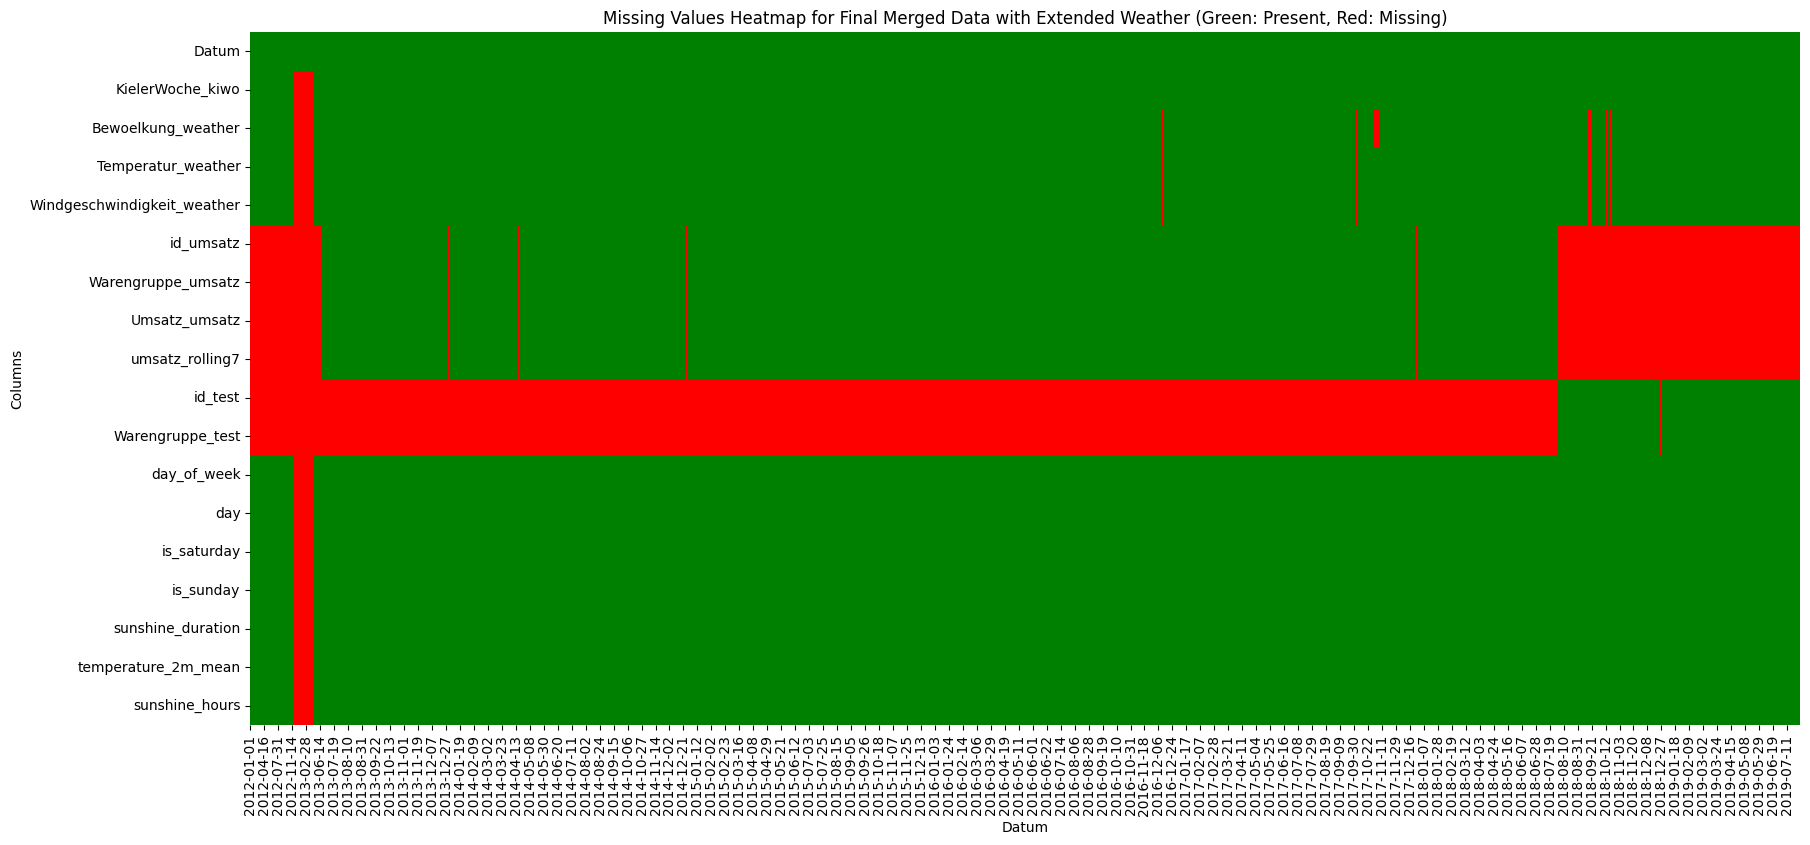

In [78]:
df_no_weather_code['Datum'] = pd.to_datetime(df_no_weather_code['Datum'])
df_extra_weather['Datum'] = pd.to_datetime(df_extra_weather['Datum'])

df_merged_extended_weather = df_no_weather_code.merge(
    df_extra_weather,
    left_on='Datum',
    right_on='Datum',
    how='left'
)


print(f"Merged DataFrame Rows: {len(df_merged_extended_weather)}")
print(f"Merged DataFrame Shape: {df_merged_extended_weather.shape}")

#df_merged_extended_weather = df_merged_extended_weather.dropna(subset=["id_umsatz"])
#df_merged_extended_weather["id_umsatz"] = df_merged_extended_weather["id_umsatz"].astype("int64")
#df_merged_extended_weather = df_merged_extended_weather.dropna(subset=["KielerWoche_kiwo"])
#df_merged_extended_weather["KielerWoche_kiwo"] = df_merged_extended_weather["KielerWoche_kiwo"].astype("int64")

df_merged_extended_weather.head()

plot_missing_heatmap(df_merged_extended_weather, 'Final Merged Data with Extended Weather')


Merged DataFrame with Holidays Rows: 11607
Merged DataFrame with Holidays Shape: (11607, 21)


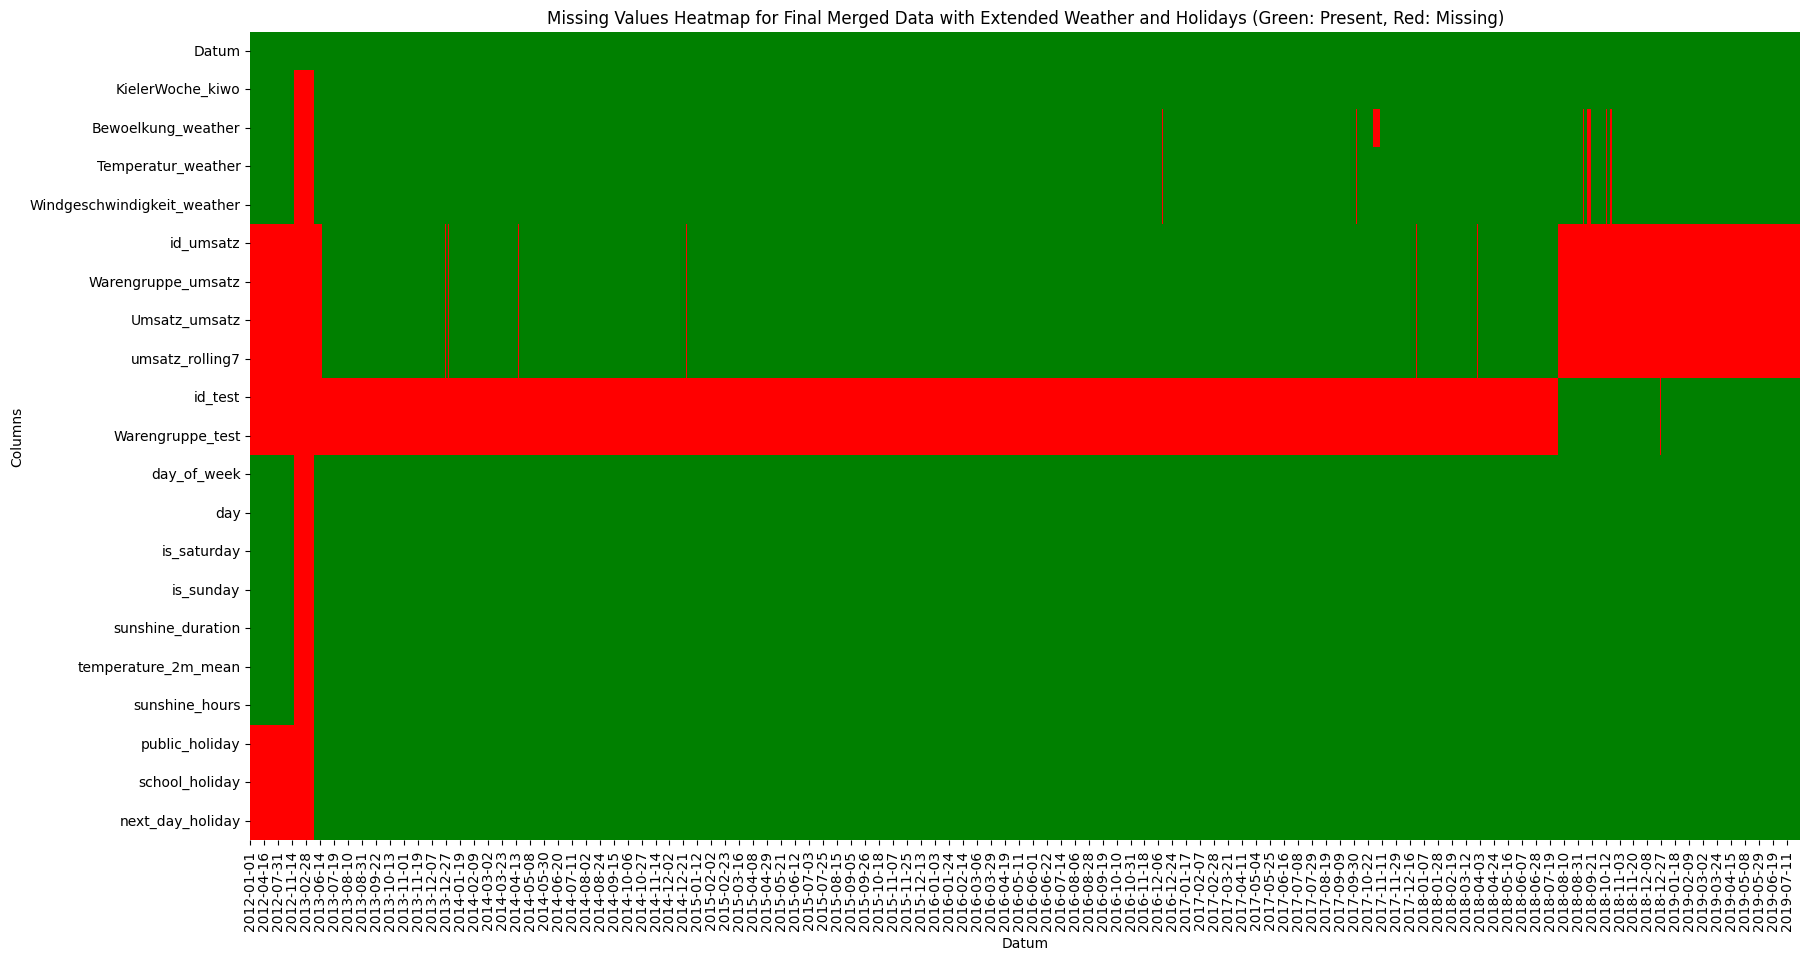

In [79]:
# read processed/df_holidays.csv
df_holidays = pd.read_csv("../data/processed/df_holidays.csv")
# rename date to datum and date type to datetime
df_holidays = df_holidays.rename(columns={"date": "Datum"})
df_holidays['Datum'] = pd.to_datetime(df_holidays['Datum'])
df_holidays.head()

# merge df_merged_extended_weather with df_holidays on Datum
df_merged_extended_weather_holidays = df_merged_extended_weather.merge(
    df_holidays,
    left_on='Datum',
    right_on='Datum',
    how='left'
)
print(f"Merged DataFrame with Holidays Rows: {len(df_merged_extended_weather_holidays)}")
print(f"Merged DataFrame with Holidays Shape: {df_merged_extended_weather_holidays.shape}")
df_merged_extended_weather_holidays.head()

plot_missing_heatmap(df_merged_extended_weather_holidays, 'Final Merged Data with Extended Weather and Holidays')

In [80]:
# write complete df_merged_extended_weather to ../data/processed/df_extended_extras_with_test.csv
df_merged_extended_weather_holidays.to_csv("../data/processed/df_extended_extras_with_test.csv", index=False)

# Splitting above df_merged_extended_weather_holidays

In [81]:
# we will split this raw data frame into train, validation, test in the next steps 
# training dataset from 01.07.2013 to 31.07.2017, a validation dataset from 01.08.2017 to 31.07.2018, and the test set from 01.08.2018 to 31.07.2019

df_train_data_raw = df_merged_extended_weather_holidays[
    (df_merged_extended_weather_holidays['Datum'] >= '2013-07-01') &
    (df_merged_extended_weather_holidays['Datum'] <= '2017-07-31')
]
df_validation_data_raw = df_merged_extended_weather_holidays[
    (df_merged_extended_weather_holidays['Datum'] >= '2017-08-01') &
    (df_merged_extended_weather_holidays['Datum'] <= '2018-07-31')
]
df_test_data_raw = df_merged_extended_weather_holidays[
    (df_merged_extended_weather_holidays['Datum'] >= '2018-08-01') &
    (df_merged_extended_weather_holidays['Datum'] <= '2019-07-31')
]

#print shapes of the three dataframes
print(f"Train Data Raw Shape: {df_train_data_raw.shape}")
print(f"Validation Data Raw Shape: {df_validation_data_raw.shape}")
print(f"Test Data Raw Shape: {df_test_data_raw.shape}")

Train Data Raw Shape: (7523, 21)
Validation Data Raw Shape: (1849, 21)
Test Data Raw Shape: (1840, 21)


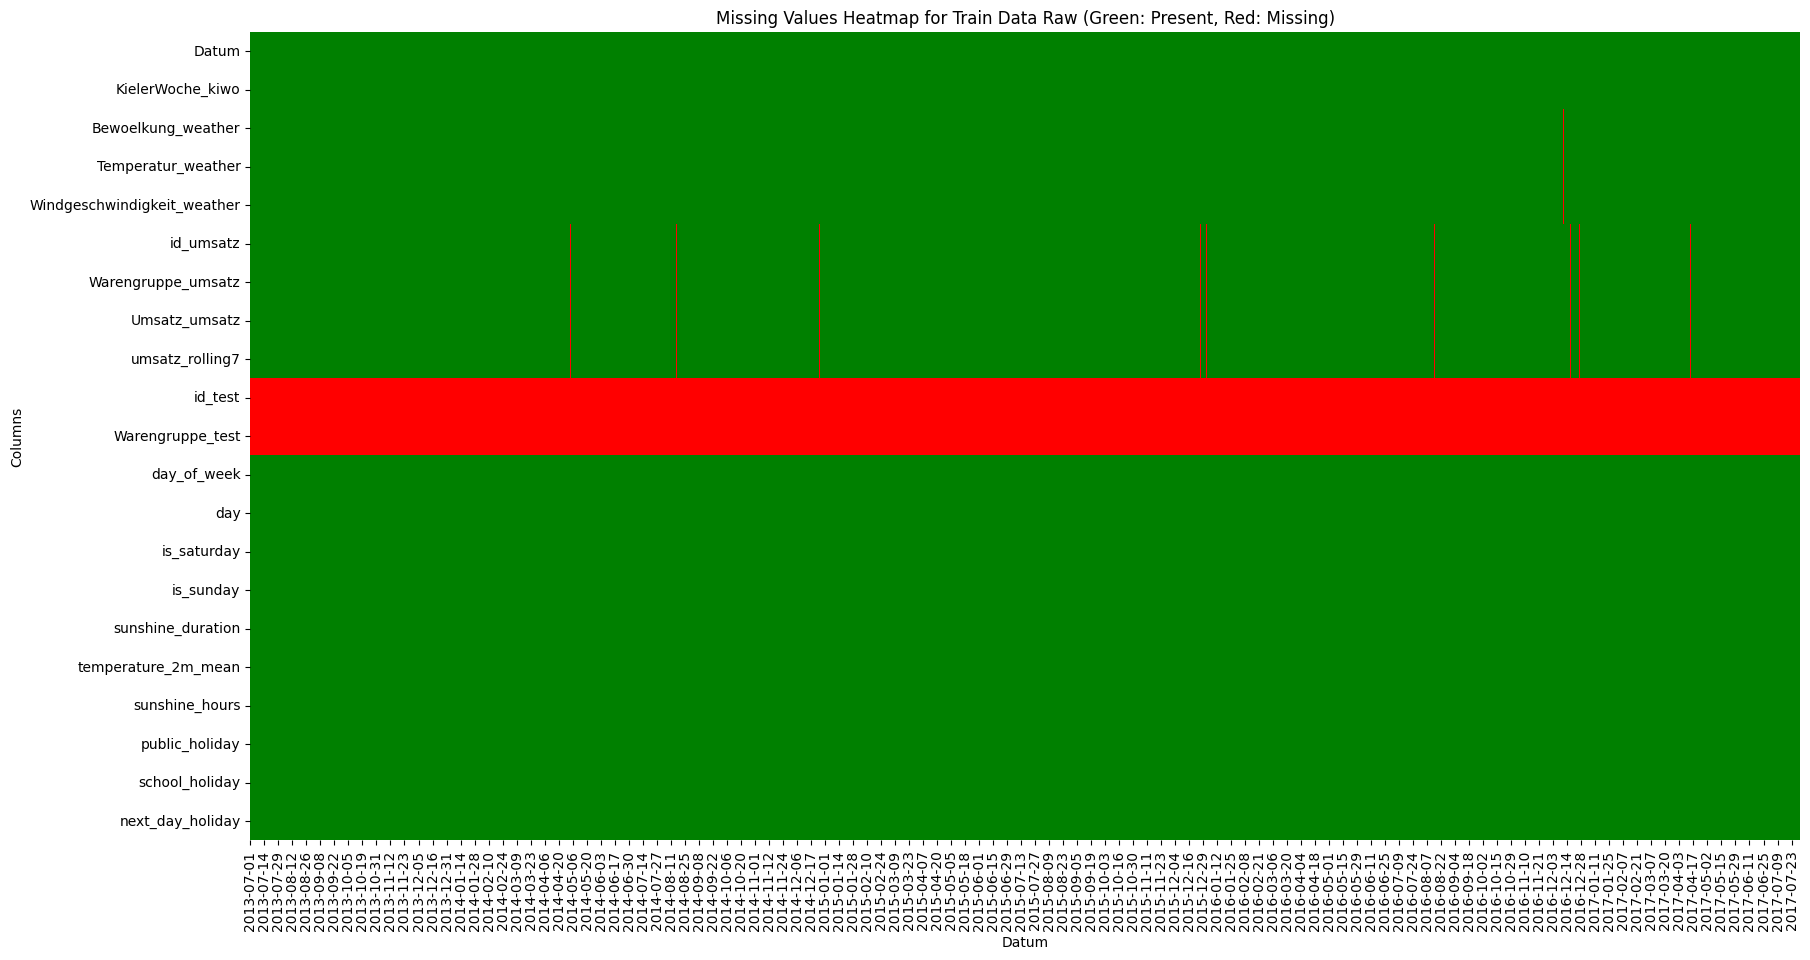

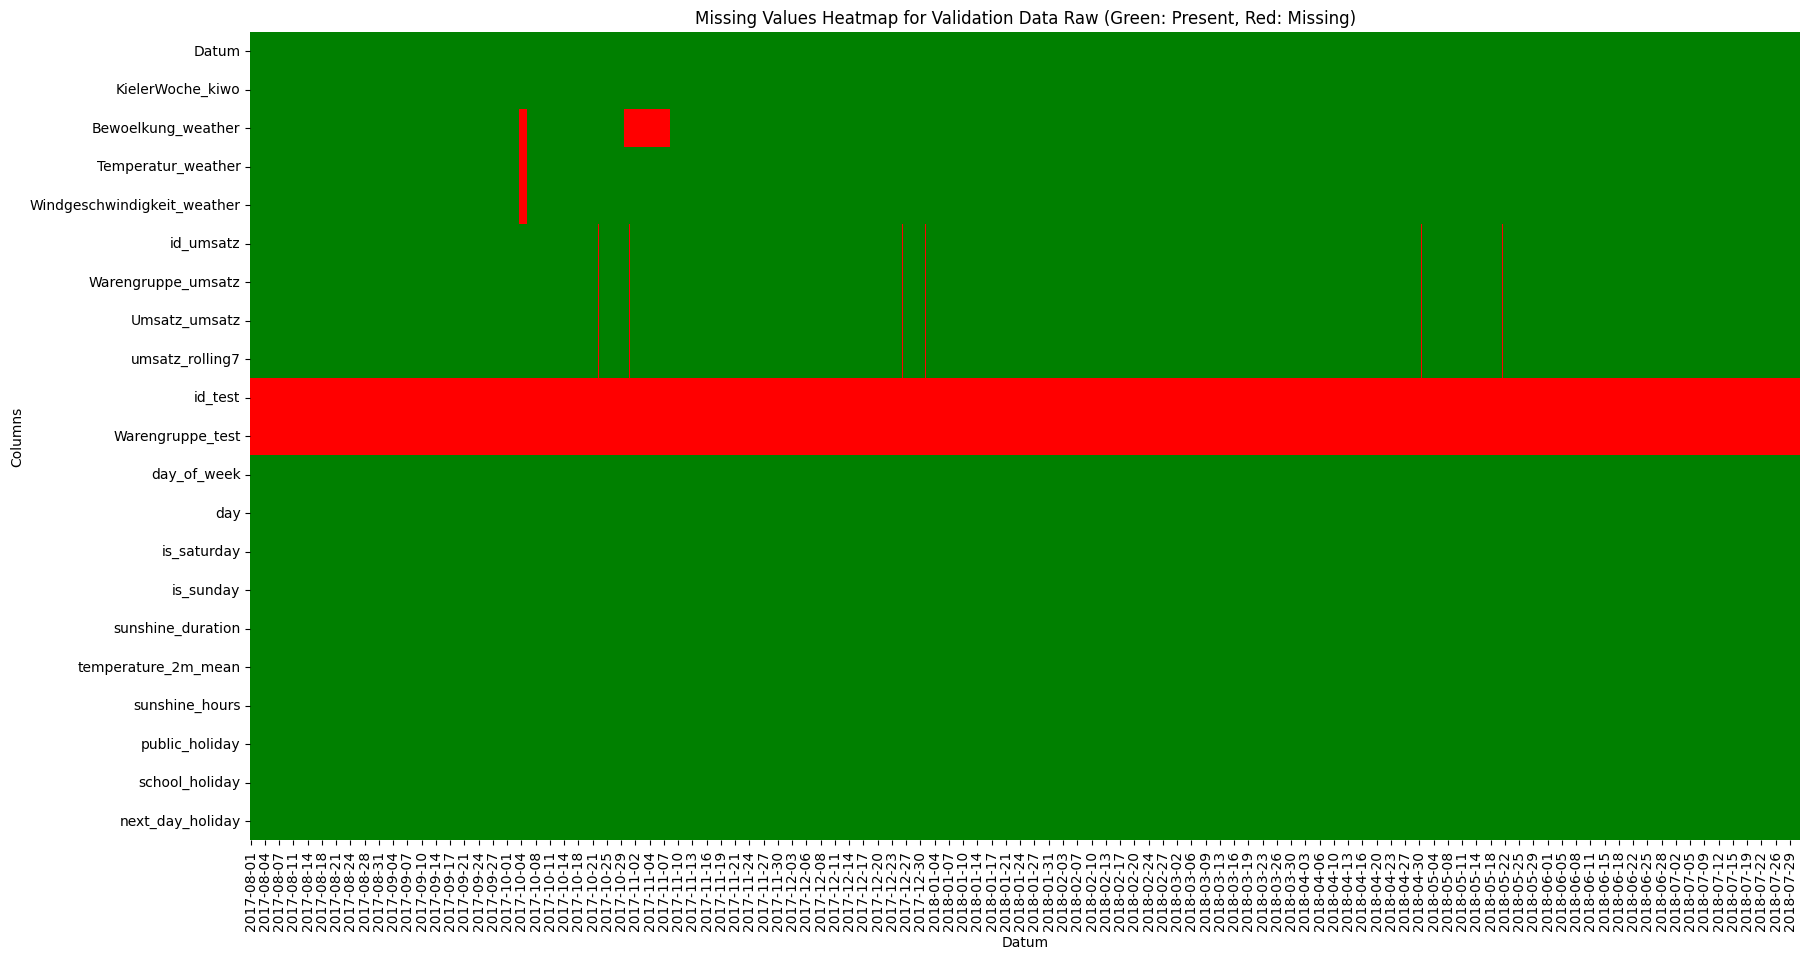

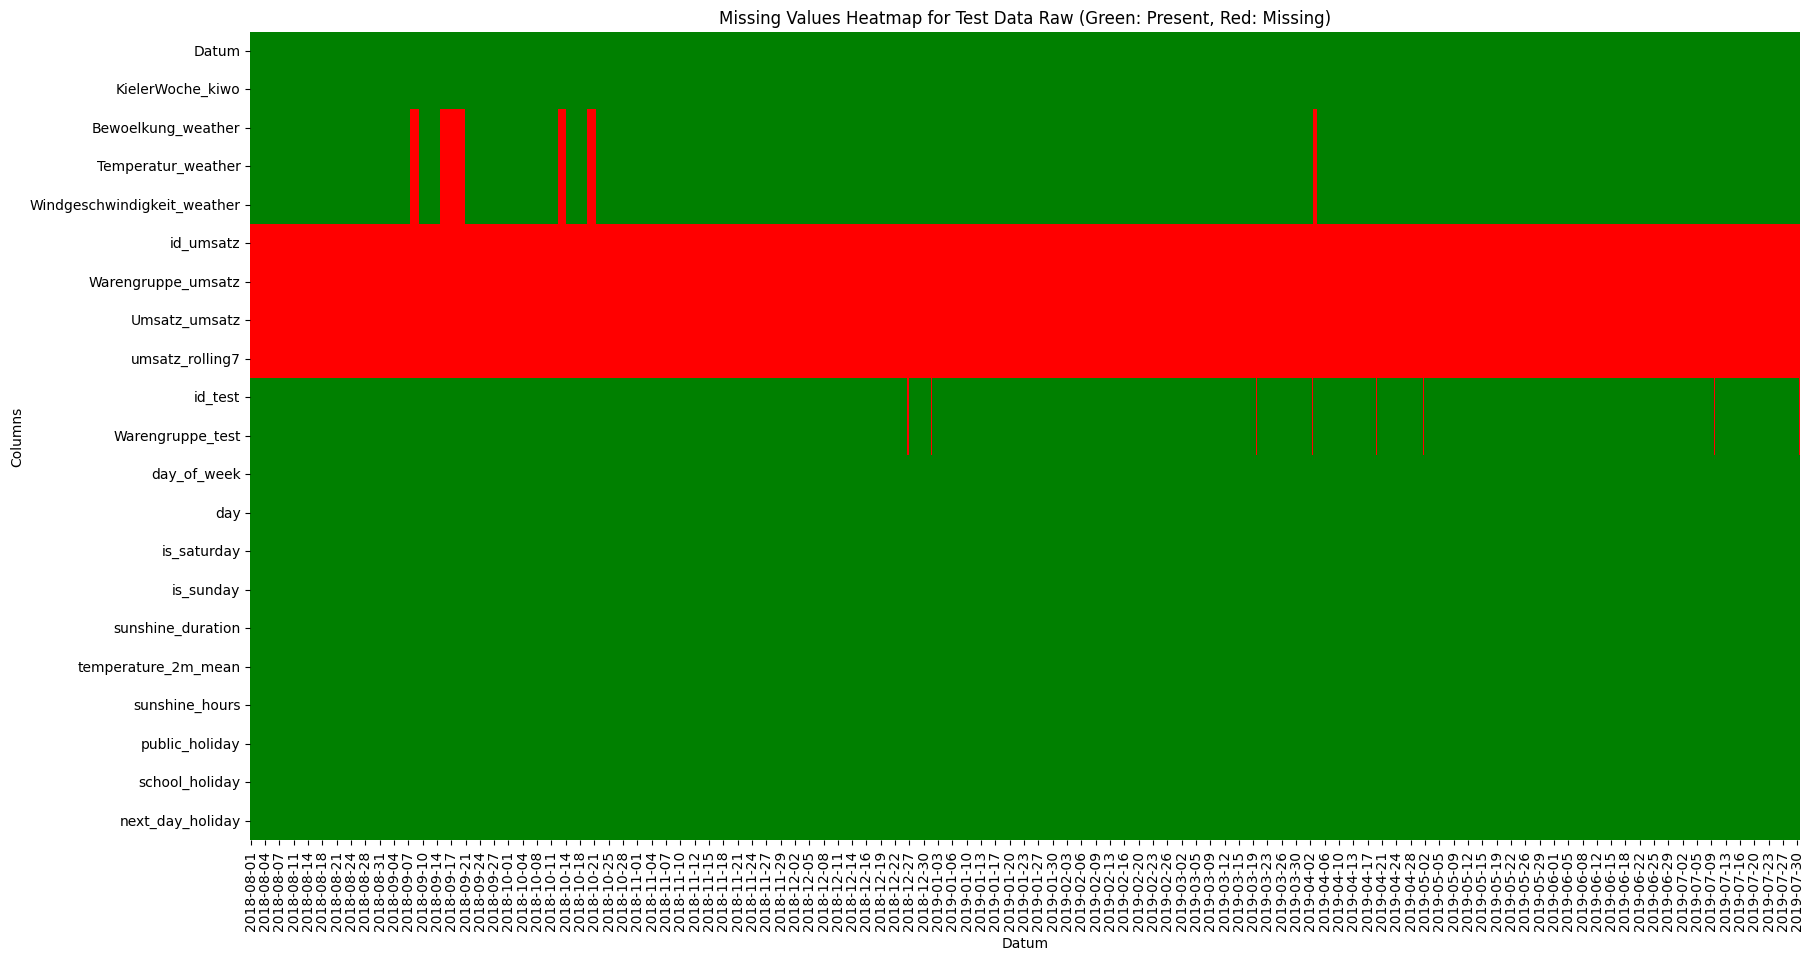

In [82]:
plot_missing_heatmap(df_train_data_raw, 'Train Data Raw')
plot_missing_heatmap(df_validation_data_raw, 'Validation Data Raw')
plot_missing_heatmap(df_test_data_raw, 'Test Data Raw')

In [83]:
# write all three dataframes to csv files
df_train_data_raw.to_csv("../data/processed/df_train_data_raw.csv", index=False)
df_validation_data_raw.to_csv("../data/processed/df_validation_data_raw.csv", index=False)
df_test_data_raw.to_csv("../data/processed/df_test_data_raw.csv", index=False)

# Cleaning raw sets for na and interpolation
## Training Set 


/tmp/ipykernel_6092/1816409684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_data_raw['Datum'] = pd.to_datetime(df_train_data_raw['Datum'])


(7523, 21)

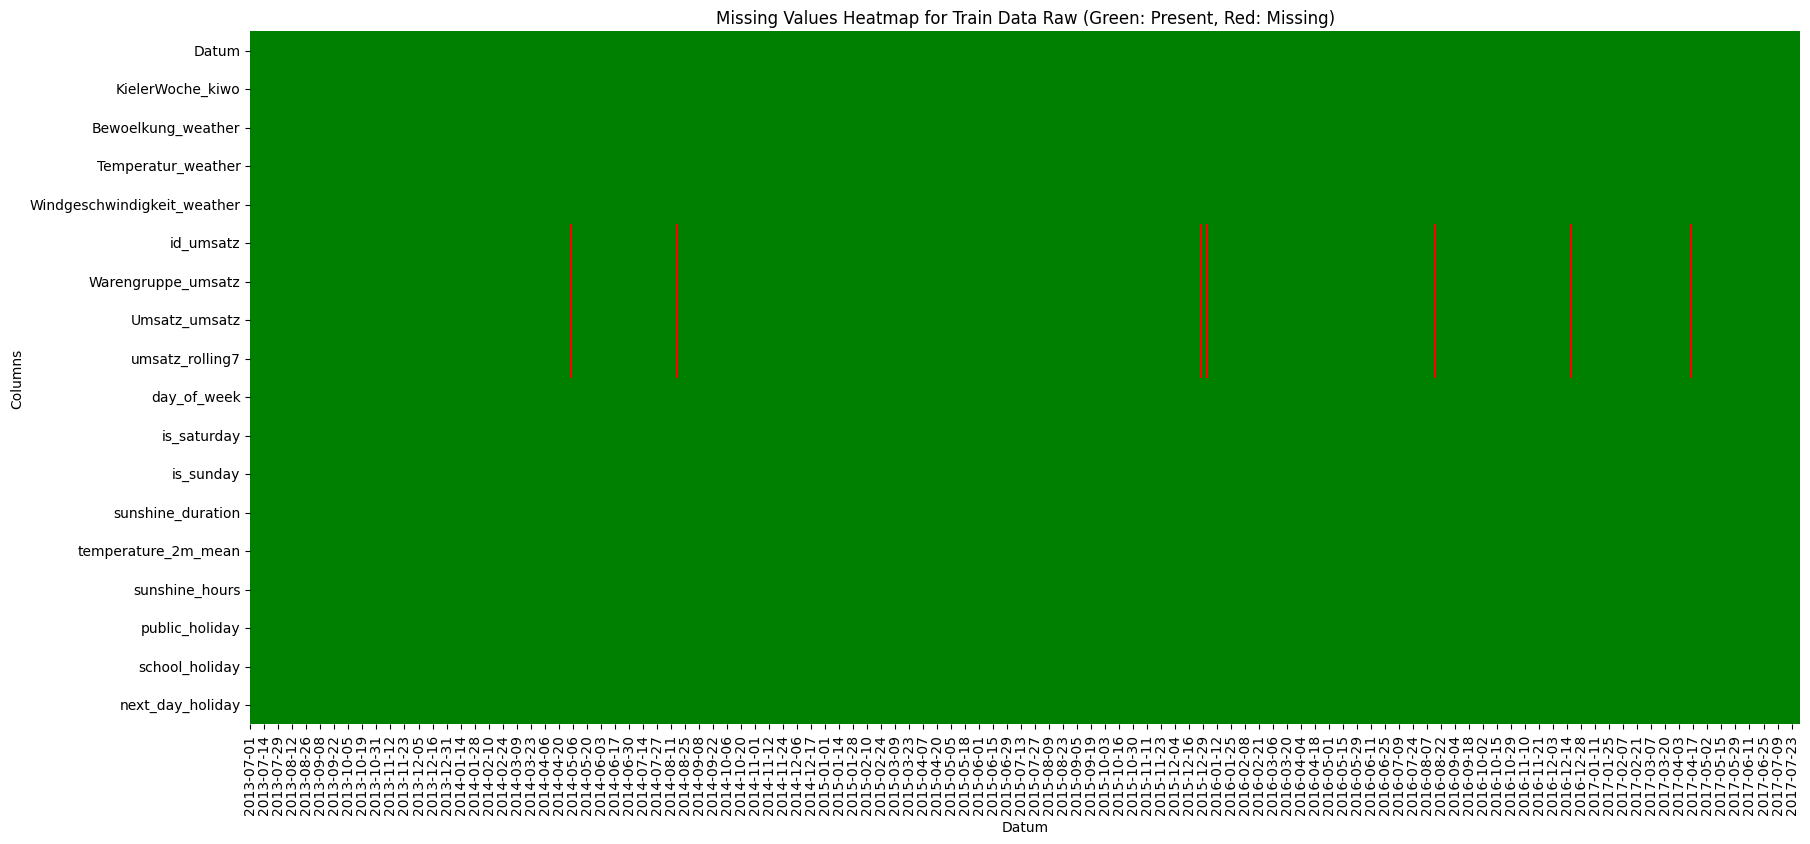

Train Data Raw Cleaned Shape: (7487, 17)


Datum                          0
KielerWoche_kiwo               0
Bewoelkung_weather             0
Temperatur_weather             0
Windgeschwindigkeit_weather    0
Warengruppe_umsatz             0
Umsatz_umsatz                  0
umsatz_rolling7                0
day_of_week                    0
is_saturday                    0
is_sunday                      0
sunshine_duration              0
temperature_2m_mean            0
sunshine_hours                 0
public_holiday                 0
school_holiday                 0
next_day_holiday               0
dtype: int64

In [84]:
df_train_data_raw['Datum'] = pd.to_datetime(df_train_data_raw['Datum'])
display(df_train_data_raw.shape)
# drop test specific columns id_test, Warengruppe_test, day
df_train_data_cleaned = df_train_data_raw.drop(columns=['id_test','Warengruppe_test','day'])
plot_missing_heatmap(df_train_data_cleaned, 'Train Data Raw')
# drop complete row where Umsatz_umsatz is NaN and Warengruppe_umsatz is NaN
df_train_data_cleaned = df_train_data_cleaned.dropna(subset=['Umsatz_umsatz', 'Warengruppe_umsatz','Temperatur_weather'])
df_train_data_cleaned = df_train_data_cleaned.drop(columns=['id_umsatz'])
print(f"Train Data Raw Cleaned Shape: {df_train_data_cleaned.shape}")
display(df_train_data_cleaned.isna().sum())

# write cleaned train data to csv
df_train_data_cleaned.to_csv("../data/processed/df_train_data_cleaned.csv", index=False)

## Validation Set

In [85]:
df_validation_data_raw['Datum'] = pd.to_datetime(df_validation_data_raw['Datum'])
display(df_validation_data_raw.shape)
#drop id_test and id_umsatz column from validation
df_validation_data_cleaned = df_validation_data_raw.drop(columns=['id_test','id_umsatz','Warengruppe_test','day'])
# print shape after dropping rows
print(f"Validation Data Raw Cleaned Shape: {df_validation_data_cleaned.shape}")


## interpolate temperaterautre data
df_validation_data_cleaned = df_validation_data_cleaned.sort_values('Datum').reset_index(drop=True)
df_validation_data_cleaned['Temperatur_weather'] = df_validation_data_cleaned['Temperatur_weather'].interpolate(method='linear')
df_validation_data_cleaned['Bewoelkung_weather'] = df_validation_data_cleaned['Bewoelkung_weather'].interpolate(method='linear')
df_validation_data_cleaned['Windgeschwindigkeit_weather'] = df_validation_data_cleaned['Windgeschwindigkeit_weather'].interpolate(method='linear')
# add month to df_validation_data_cleaned
df_validation_data_cleaned['month'] = df_validation_data_cleaned['Datum'].dt.month

# drop complete row where Umsatz_umsatz is NaN and Warengruppe_umsatz is NaN
df_validation_data_cleaned = df_validation_data_cleaned.dropna(subset=['Umsatz_umsatz', 'Warengruppe_umsatz'])
#plot_missing_heatmap(df_validation_data_cleaned, 'Validation Data Cleaned')
# print na value counts of df_validation_data_cleaned
display(df_validation_data_cleaned.isna().sum())

# write cleaned validation data to csv
df_validation_data_cleaned.to_csv("../data/processed/df_validation_data_cleaned.csv", index=False)

/tmp/ipykernel_6092/2359809688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation_data_raw['Datum'] = pd.to_datetime(df_validation_data_raw['Datum'])


(1849, 21)

Validation Data Raw Cleaned Shape: (1849, 17)


Datum                          0
KielerWoche_kiwo               0
Bewoelkung_weather             0
Temperatur_weather             0
Windgeschwindigkeit_weather    0
Warengruppe_umsatz             0
Umsatz_umsatz                  0
umsatz_rolling7                0
day_of_week                    0
is_saturday                    0
is_sunday                      0
sunshine_duration              0
temperature_2m_mean            0
sunshine_hours                 0
public_holiday                 0
school_holiday                 0
next_day_holiday               0
month                          0
dtype: int64

## Test Set

/tmp/ipykernel_6092/3212728736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data_raw['Datum'] = pd.to_datetime(df_test_data_raw['Datum'])


(1840, 21)

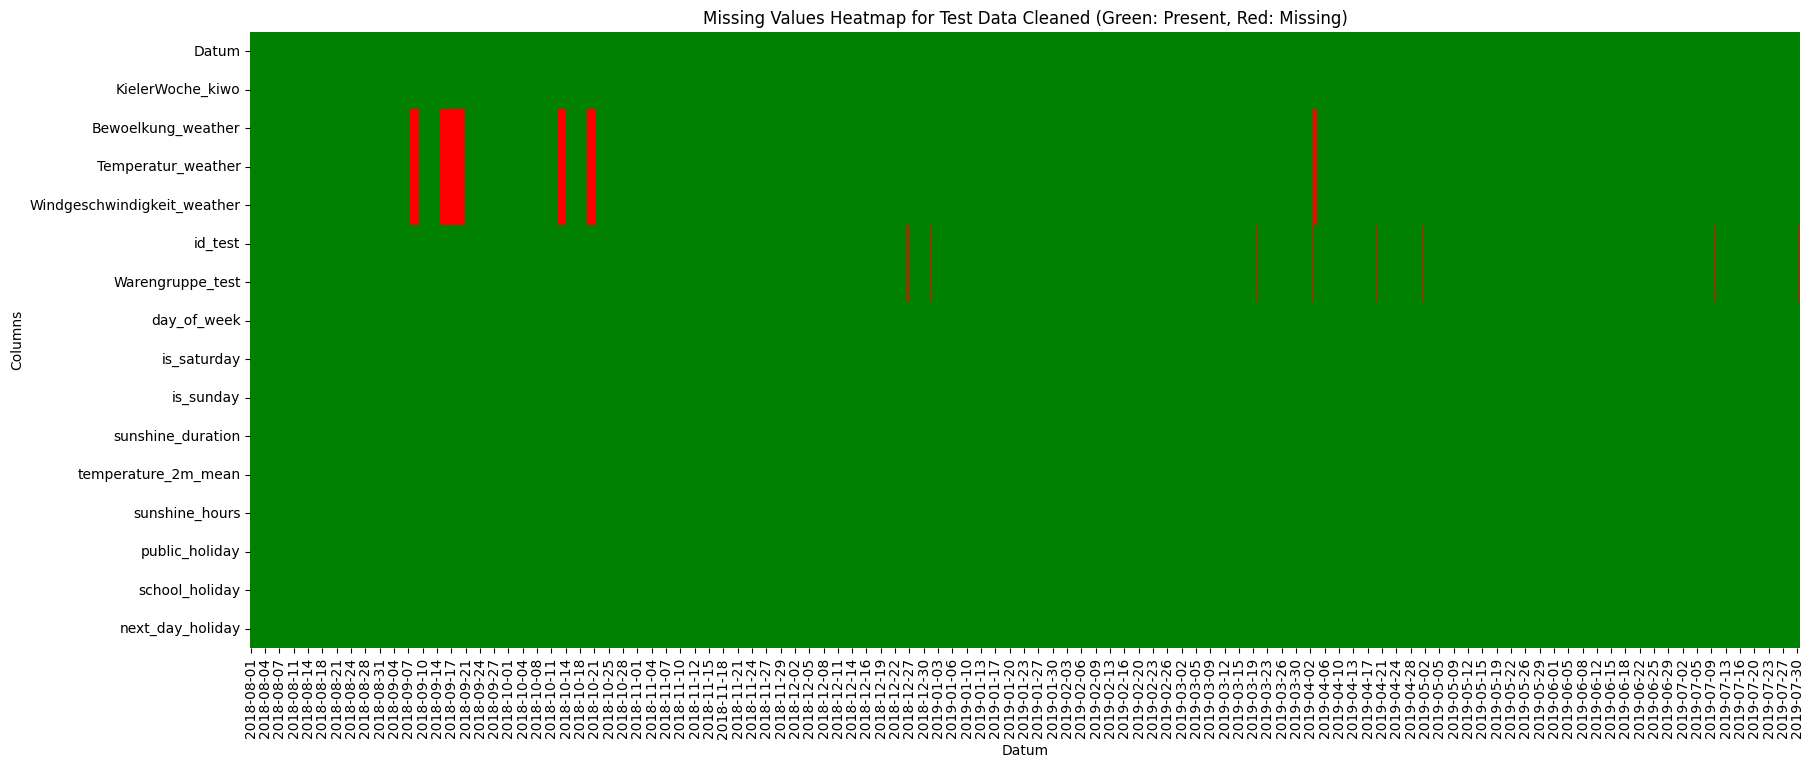

(1830, 16)

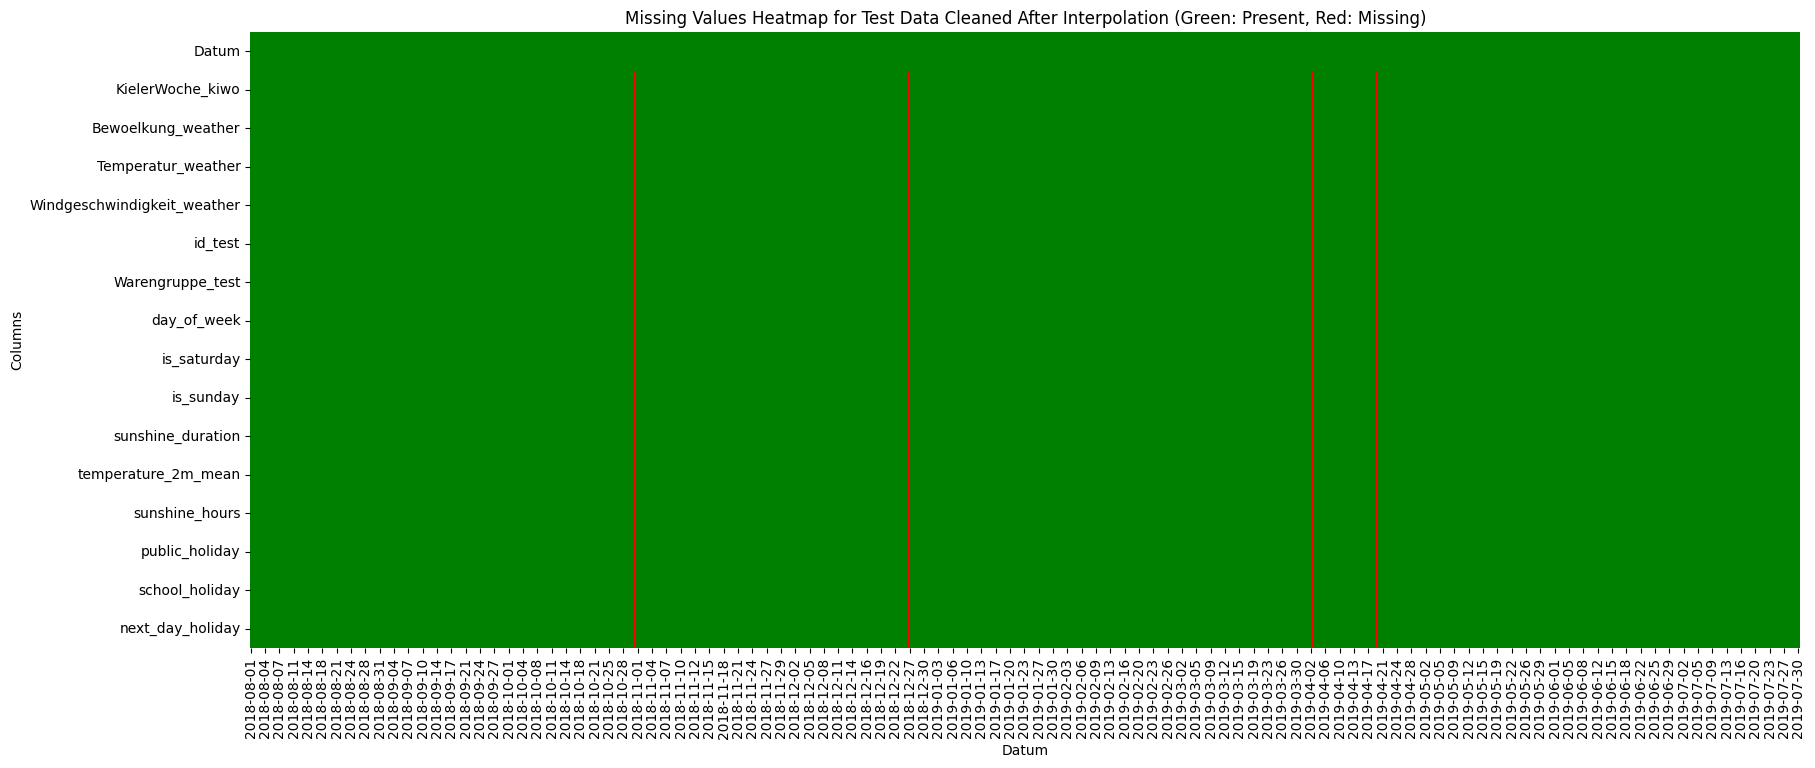

KeyError: 'id'

In [ ]:

df_test_data_raw['Datum'] = pd.to_datetime(df_test_data_raw['Datum'])
display(df_test_data_raw.shape)
# check na sums

#display(df_test_data_raw.isna().sum())
df_test_data_cleaned = df_test_data_raw.drop(columns=['id_umsatz','Warengruppe_umsatz','Umsatz_umsatz','umsatz_rolling7','day'])
plot_missing_heatmap(df_test_data_cleaned, 'Test Data Cleaned')

# drop where id_test is NaN
df_test_data_cleaned = df_test_data_cleaned.dropna(subset=['id_test'])
display(df_test_data_cleaned.shape)

# linearly interpolate for df_test_data_cleaned
df_test_data_cleaned = df_test_data_cleaned.sort_values('Datum').reset_index(drop=True)
df_test_data_cleaned['Temperatur_weather'] = df_test_data_cleaned['Temperatur_weather'].interpolate(method='linear')
df_test_data_cleaned['Bewoelkung_weather'] = df_test_data_cleaned['Bewoelkung_weather'].interpolate(method='linear')
df_test_data_cleaned['Windgeschwindigkeit_weather'] = df_test_data_cleaned['Windgeschwindigkeit_weather'].interpolate(method='linear')

plot_missing_heatmap(df_test_data_cleaned, 'Test Data Cleaned After Interpolation')

#rename id_test	Warengruppe_test to id	Warengruppe
df_test_data_cleaned = df_test_data_cleaned.rename(columns={"id_test": "id", "Warengruppe_test": "Warengruppe_umsatz"})
# change id to int
df_test_data_cleaned["id"] = df_test_data_cleaned["id"].astype("int64")

display(df_test_data_cleaned.head())

# write cleaned test data to csv
df_test_data_cleaned.to_csv("../data/processed/df_test_data_cleaned.csv", index=False)  

